<a href="https://colab.research.google.com/github/Nadian-Ali/GeoImageClassificaiton/blob/main/train_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#what is 236?  got it!

#same rock / different depth / different pattern /// same class? or two classes? 

In [ ]:
!python --version

Python 3.7.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive'



/content/drive/My Drive


In [ ]:
import os 
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [ ]:

Alis = 'Projects/GeoImageClassification/data'
folder_location_in_drive= os.path.join(os.getcwd(),Alis)

file_names = [f for f in listdir(folder_location_in_drive) if( f.split('.')[-1]=='las' and isfile(join(folder_location_in_drive, f)))] #get list of the files with las extension 


In [ ]:

# the FMI_reader function reads the .las files that contain FMI resistivity values.
# the output of the function is two numpy arrays 
#1. data which is 2D array with 192 colums and rows equal to the number of depth samples 
#2. the depth array which is a 1D array and contains all the depth
# samples
def FMI_reader(path):
    # f = open(path, 'r')
    # content = f.readlines()
    # f.close()
    with open(path,'r') as file:
      content  = file.readlines()
    data = []
    depth = []
    rock_type = path.split('.')[0].split('_')[0].split('/')[-1]
    for L in content:
        L = L.split(' ')
        res = [st for st in L if st != "" and st != '\n']
        if res[0] == '~Ascii':
            continue
        elif res[0] == '~Version':
            break
        elif len(res) == 1:
            depth.append(float(res[0]))
        else:
            data.extend(list(map(float, res)))

    data = np.array(data)
    depth = np.array(depth)
    data = np.reshape(data, (-1, 192))

    return data, depth, rock_type

In [ ]:
Data = []
Depth = []
Rock_Type = []

for file in file_names:
  path = os.path.join( os.path.join(os.getcwd(),Alis,file))
  print(path)
  if 'full' not in path:
      
    # print(path)
    # path = '/content/drive/MyDrive/Projects/GeoSampleClassification/data/SstLoa_1.las'
    data,depth,rock_type = FMI_reader(path)
    Data.append(data)
    Depth.append(depth)
    Rock_Type.append(rock_type)
    # cv2_imshow(data)
    print(np.shape(data))
    # print(rock_type)
    # cv2_imshow(data)
    # print(rock_type)

/content/drive/My Drive/Projects/GeoImageClassification/data/SstLoa_1.las
(236, 192)
/content/drive/My Drive/Projects/GeoImageClassification/data/SstLoa_2.las
(393, 192)
/content/drive/MyDrive/Projects/GeoImageClassification/data/SstHia_1.las
(472, 192)
/content/drive/MyDrive/Projects/GeoImageClassification/data/SstHia_2.las
(433, 192)
/content/drive/MyDrive/Projects/GeoImageClassification/data/CemtLa_1.las
(276, 192)
/content/drive/MyDrive/Projects/GeoImageClassification/data/CemtLa_2.las
(40, 192)
/content/drive/MyDrive/Projects/GeoImageClassification/data/HetLoc_1.las
(314, 192)
/content/drive/MyDrive/Projects/GeoImageClassification/data/HetLoc_2.las
(314, 192)
/content/drive/MyDrive/Projects/GeoImageClassification/data/HetHic_2.las
(117, 192)
/content/drive/MyDrive/Projects/GeoImageClassification/data/HetHic_1.las
(314, 192)


In [ ]:
print('The samples in Data and Rock_Type are {} and {} respectively'.format(len(Data),len(Rock_Type)))

The samples in Data and Rock_Type are 10 and 10 respectively


In [ ]:
Rock_Type

['SstLoa',
 'SstLoa',
 'SstHia',
 'SstHia',
 'CemtLa',
 'CemtLa',
 'HetLoc',
 'HetLoc',
 'HetHic',
 'HetHic']

In [ ]:
classes = ['SstLoa', 'SstHia','CemtLa','HetLoc','HetHic']
cls = {Key:Label for Label,Key in enumerate(classes)}
Dta = np.array(Data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
np.shape(Dta[0])

(236, 192)

<h1> Create new dataset</h1>

In [98]:
num_samples = 10
offset  = 192 
IM_Size = 192
def create_sample(im,IM_SIZE):
  rng = np.random.default_rng()
  indexable = np.shape(im)[0]- np.shape(im)[1]
  # print)
  if indexable <= 0:

    # print(indexable)
    im = np.pad(im,((0,abs(indexable)),(0,0)), mode = 'reflect')
    indexable = np.shape(im)[0]- np.shape(im)[1]
    idx = 0
    img = np.array(im[idx:idx+IM_SIZE,:])
    # random x rolling 
    rots = rng.choice(range(IM_SIZE),size = 2, replace = True)
    
    img = np.roll(img,rots[0],axis = 0)
    img = np.roll(img,rots[1],axis = 1)
    return img, indexable

 
  idx = rng.choice(range(indexable))
  # print(idx)
  rots = rng.choice(range(IM_SIZE),size = 2, replace = True)
  
  # print(rots)

  #sample data based on index to create IM_size,IM_size sample
  img = np.array(im[idx:idx+IM_SIZE,:])
  # random x rolling 
  img = np.roll(img,rots[0],axis = 0)
  img = np.roll(img,rots[1],axis = 1)
  return img, indexable


In [99]:
SAMPLES = 100
IM_SIZE = 192
X = []
lable = []
for idx,a_sample in enumerate(Dta):
  
  print(idx)
  lbl = cls[Rock_Type[idx]]
  for s in range(SAMPLES):
    sample ,tx = create_sample(a_sample,IM_SIZE)
  
    # if (s%10==0):
    #   cv2_imshow(sample)
    s = np.expand_dims(np.array(sample),axis=0)
    s = np.moveaxis(s,0,-1)
    # print(np.shape(s))
    X.append(s)
    lable.append(lbl)

    
  


0
1
2
3
4
5
6
7
8
9


In [78]:
192/4


48.0

In [100]:
X = np.array(X)/255
y = lable
clses = tf.keras.utils.to_categorical(np.array(y), num_classes=None, dtype="int")

In [101]:


print('number of smaple is {} and num of lables is {}'.format(np.shape(X),len(clses)))

number of smaple is (1000, 192, 192, 1) and num of lables is 1000


In [ ]:
clses[0]

array([1, 0, 0, 0, 0])

In [102]:
X_train = X
clses_train = clses

In [105]:
input = (IM_SIZE,IM_SIZE,1)
inputs = tf.keras.Input(shape = input)
x = layers.Conv2D(16,kernel_size=(5,5), 	 activation='relu')(inputs)
# x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32,	 kernel_size=(3,3), 	 activation='relu')(x)
x = layers.Conv2D(32,	 kernel_size=(3,3), 	 activation='relu')(x)
# x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64,	 kernel_size=(3,3), 	 activation='relu')(x)
# x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
# x = layers.Dropout(.5)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(.5)(x)
y = layers.Dense(5, activation='softmax')(x)
# y = layers.Dense(5)(x)



In [106]:
model = Model(inputs=inputs, outputs=y)
model.summary() 

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 192, 192, 1)]     0         
                                                                 
 conv2d_60 (Conv2D)          (None, 188, 188, 16)      416       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 94, 94, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 92, 92, 32)        4640      
                                                                 
 conv2d_62 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                     

<h1> Define optimizers </h1>

In [107]:
Adamoptimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    # beta_1=0.9,
    # beta_2=0.999,
    # epsilon=1e-07,
    # amsgrad=False,
    name="Adam",
    # **kwargs
)

SGDoptimizer = tf.keras.optimizers.SGD(
    learning_rate=0.0001, momentum=0.0, nesterov=False)

RMSoptimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    # centered=False,
    # name="RMSprop",
    # **kwargs
)




In [ ]:
type(clses_train)

numpy.ndarray

In [ ]:
clses_train[0]

array([1, 0, 0, 0, 0])

In [108]:

model = Model(inputs=inputs, outputs=y)

model.compile(loss='categorical_crossentropy',
              optimizer = RMSoptimizer,
              
              metrics=['accuracy']) 

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=clses_train,
    epochs=30,
    batch_size=32,
    validation_split = .25,
    shuffle = True,
  )
# *itsalyssaemm!

Epoch 1/30
24/24 [==============================] - 35s 1s/step - loss: 1.5419 - accuracy: 0.2987 - val_loss: 3.4162 - val_accuracy: 0.2000
Epoch 2/30
24/24 [==============================] - 34s 1s/step - loss: 1.4224 - accuracy: 0.2867 - val_loss: 4.2006 - val_accuracy: 0.0040
Epoch 3/30
24/24 [==============================] - 34s 1s/step - loss: 1.3471 - accuracy: 0.3573 - val_loss: 6.0017 - val_accuracy: 0.1040
Epoch 4/30
24/24 [==============================] - 34s 1s/step - loss: 1.2495 - accuracy: 0.3880 - val_loss: 5.9063 - val_accuracy: 0.0520
Epoch 5/30
24/24 [==============================] - 33s 1s/step - loss: 1.1720 - accuracy: 0.4120 - val_loss: 7.0301 - val_accuracy: 0.2000
Epoch 6/30
24/24 [==============================] - 34s 1s/step - loss: 1.0749 - accuracy: 0.4320 - val_loss: 9.8120 - val_accuracy: 0.2000
Epoch 7/30
24/24 [==============================] - 34s 1s/step - loss: 1.1263 - accuracy: 0.4533 - val_loss: 9.7342 - val_accuracy: 0.2000
Epoch 8/30
24/24 [==

<h1>Curves </h1>

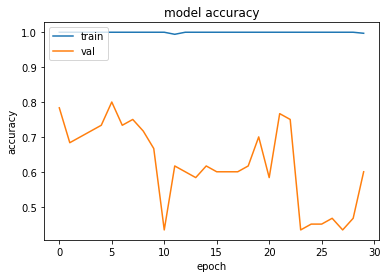

In [ ]:
from matplotlib import pyplot as plt
# history = model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

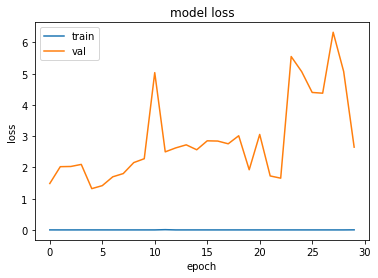

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
del model

In [ ]:
get_class_name = {val:key for val,key in enumerate(classes)}
get_class_name[0]

'SstLoa'

In [ ]:
#lets see how the model works 

test_sample = 0
predcitions = model.predict(X)
# p = get_class_name[np.argmax(predcitions)]
# g = get_class_name[lable(test_sample)]
# print('detected class is {} and the true label is {}'.format(c,g))

TypeError: ignored

In [ ]:
predcitions

array([[1.0000000e+00, 1.9128022e-11, 2.3910828e-22, 7.4692197e-10,
        0.0000000e+00],
       [1.0000000e+00, 2.4542926e-15, 6.6480387e-29, 4.3571239e-17,
        0.0000000e+00],
       [1.0000000e+00, 2.7489067e-16, 1.6196759e-25, 7.2322117e-25,
        0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00]], dtype=float32)

<KerasTensor: shape=(5,) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [ ]:

class_names


{'CemtLa': 5, 'HetHic': 9, 'HetLoc': 7, 'SstHia': 3, 'SstLoa': 1}

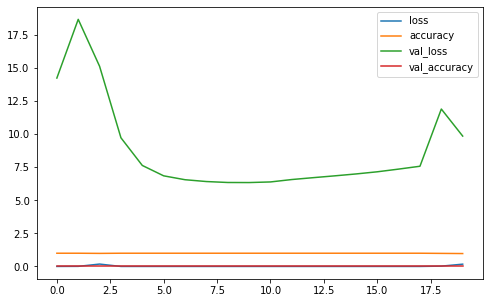

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
#get samples for one class as an example
SAMPLES = 40
IM_SIZE = 192
X = []
lable = []
idx = 0
a_sample = Dta[idx]
lbl = cls[Rock_Type[idx]]
for s in range(SAMPLES):
  sample ,IDX = create_sample(a_sample,IM_SIZE)
  print("\n")
  cv2_imshow(sample)
  X.append(np.expand_dims(np.array(sample),axis=0))
  lable.append(lbl)

In [ ]:


# dataset = np 
# # labels = 
# # create a new sample 
# # indicator i points to both the data , label 
# i = 0
# sample = Dta[i]
# label  = cls[Rock_Type[i]]
# print('the number of rows in this sample is {}'.format(np.shape(sample)))
# # the number of indexs we can select from is : 
# indexable_samples = np.shape(sample)[0] - np.shape(sample)[1]
# print('indexable_samples equals : {}'.format(indexable_samples)) 


# # random.Generator.choice(a, size=None, replace=True, p=None, axis=0, shuffle=True)
# rng = np.random.default_rng()
# samples = rng.choice(range(indexable_samples),size=num_samples,replace = False)

# for _ in samples:

#   sampled_image = Dta[i][_:_+offset] 

#   rot = rng.choice(range(IM_Size))
#   sampled_image = np.roll(sampled_image,rot,axis = 0)
#   sampled_image = np.roll(sampled_image,rot,axis = 1)
#   cv2_imshow(sampled_image)
#   print('\n')
# # np.random.Generator.choice(range(10, 13),size=10)



# # cv2_imshow(sample[:192,:])

In [ ]:
# random.Generator.choice(a, size=None, replace=True, p=None, axis=0, shuffle=True)
rng = np.random.default_rng()
indexed_samples = rng.choice(range(44),size=10,replace = False)
offset = 192 
for K in indexed_samples:
  sampled_image = Dta[i][K:K+offset] 
  cv2_imshow(sampled_image)
  print('\n')
# np.random.Generator.choice(range(10, 13),size=10)

In [ ]:
abs(-2)

2